In [15]:
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
import time
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from IPython.display import display
from scipy.stats import shapiro
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## Step 0: Preprocessing the Dataset
**Loads the dataset from the specified file path**

    - Displays dataset structure and basic statistics.

In [16]:
# Load dataset
df = pd.read_csv("creditcard.csv")
target_column = 'Class'
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove(target_column)
# Display dataset shape and first few rows
print(f"Dataset Shape: {df.shape}")
print("\nSample Rows:")
display(df.head())

Dataset Shape: (284807, 31)

Sample Rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
df_dtypes = pd.DataFrame(df.dtypes).reset_index()
df_dtypes.columns = ['Column', 'Data Type']
print(df_dtypes)

    Column Data Type
0     Time   float64
1       V1   float64
2       V2   float64
3       V3   float64
4       V4   float64
5       V5   float64
6       V6   float64
7       V7   float64
8       V8   float64
9       V9   float64
10     V10   float64
11     V11   float64
12     V12   float64
13     V13   float64
14     V14   float64
15     V15   float64
16     V16   float64
17     V17   float64
18     V18   float64
19     V19   float64
20     V20   float64
21     V21   float64
22     V22   float64
23     V23   float64
24     V24   float64
25     V25   float64
26     V26   float64
27     V27   float64
28     V28   float64
29  Amount   float64
30   Class     int64


## Step 1: Detecting and Correcting Skewed Features

In [18]:
# Detect skewed features
skewness_table = []  # List to store skewness values

print("Detecting skewed features...")
skewed_features = df[numerical_features].skew()
skewed_features = skewed_features[abs(skewed_features) > 0.5].index.tolist()
print(f"Skewed Features: {skewed_features}")
print(f"Skewness of V5: {df['V5'].skew()}")


Detecting skewed features...
Skewed Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28', 'Amount']
Skewness of V5: -2.425901495952054


### **1.1 Addressing the Issue of Worsened Skewness After Transformation**

In some cases, applying transformations actually increased the skewness rather than reducing it.
To fix this, we will implement a smarter transformation selection approach that avoids making skewness worse.

Three Improvements to Prevent Skewness Worsening:
1. Add a Post-Transformation Check:
If the skewness increases instead of decreasing, we will revert to the original data.
2. Choose a More Intelligent Transformation:
If all values are strictly positive, we apply Box-Cox.
If the feature contains negative values, we use Yeo-Johnson instead.
We avoid log transformations automatically, as they may worsen skewness in extreme cases.
3. Store the Original Skewness and Compare:
After applying a transformation, we check if skewness improved.
If the transformation made it worse, we undo the change and restore the original values.


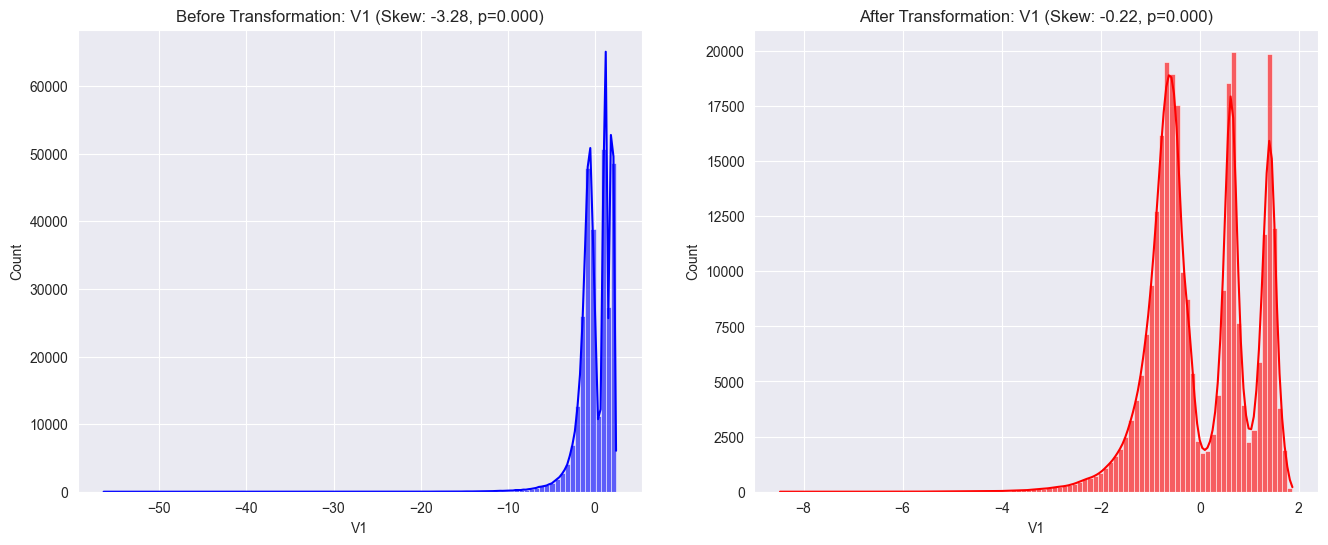

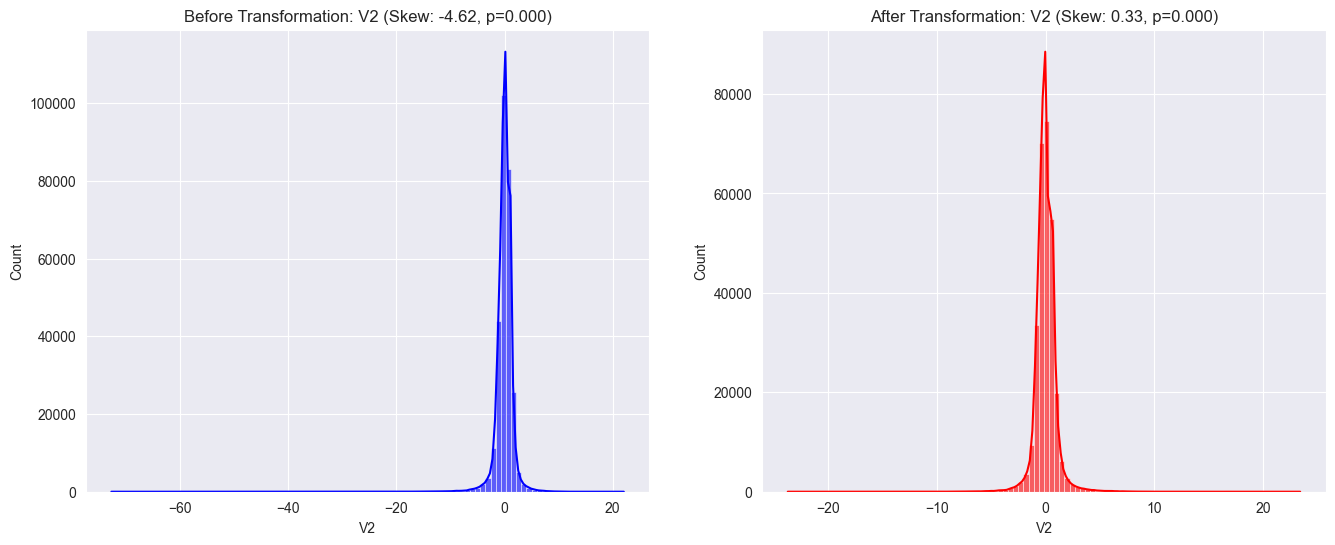

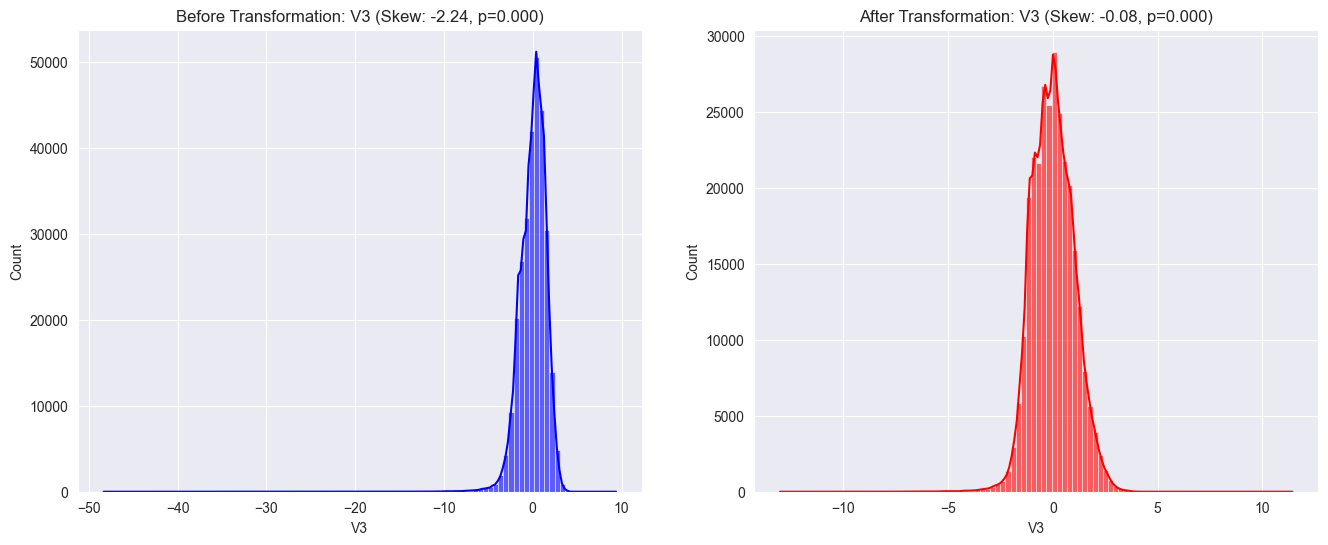

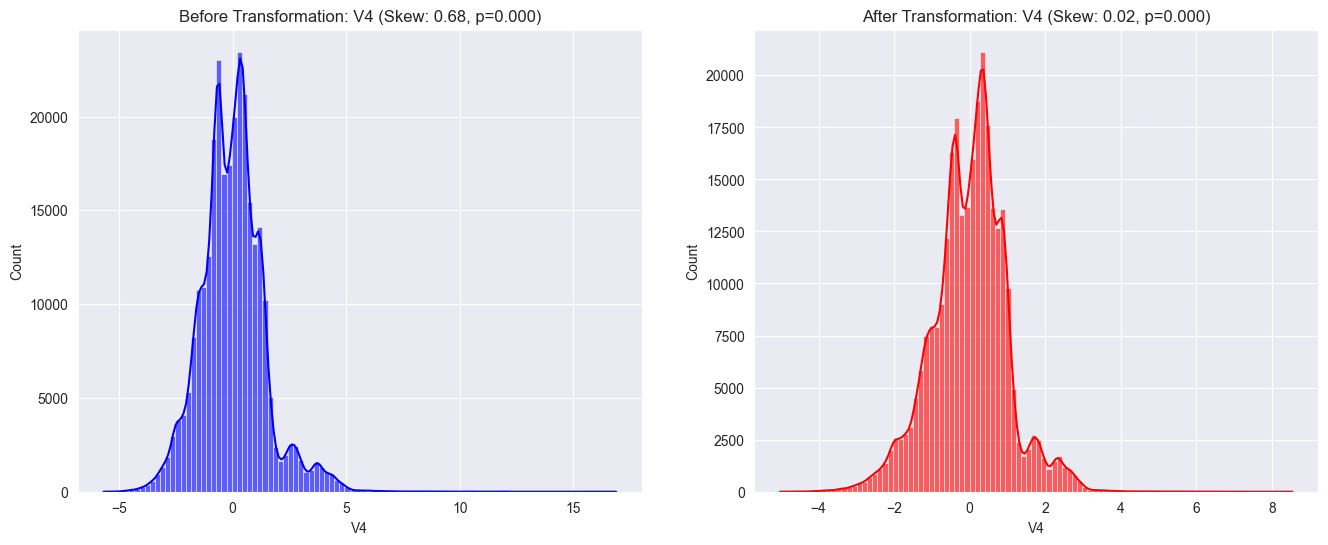

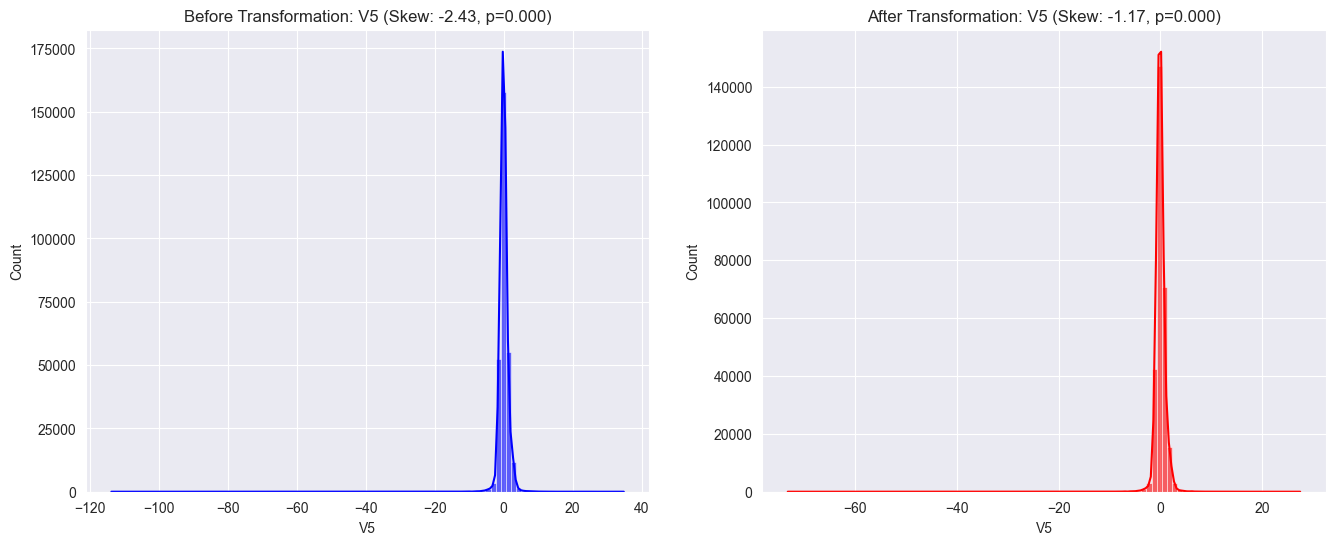

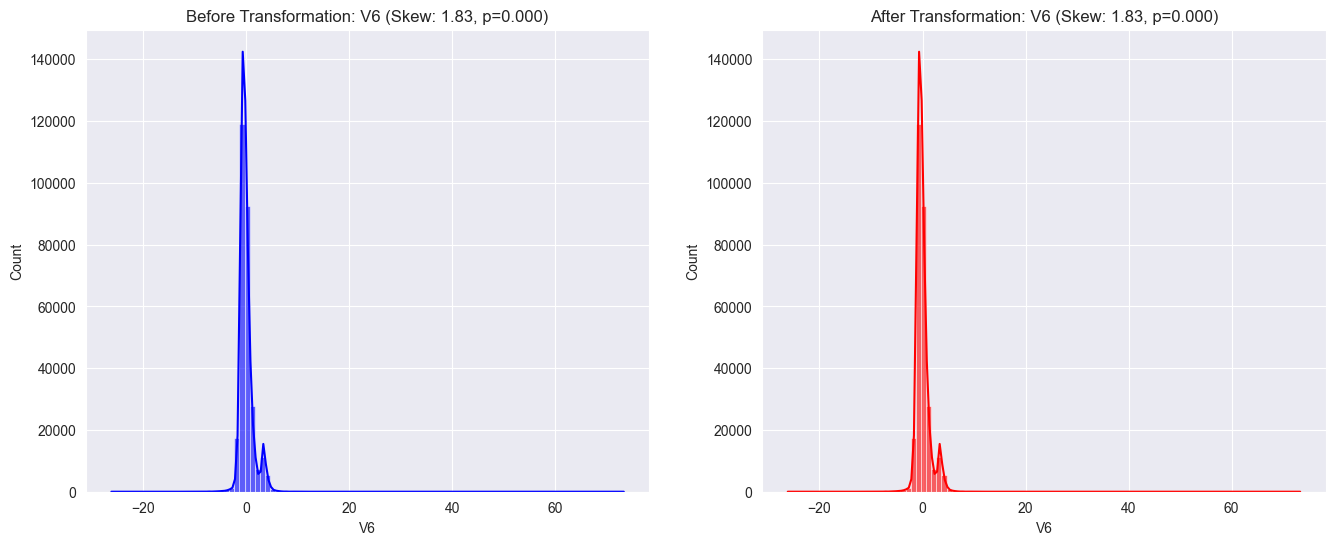

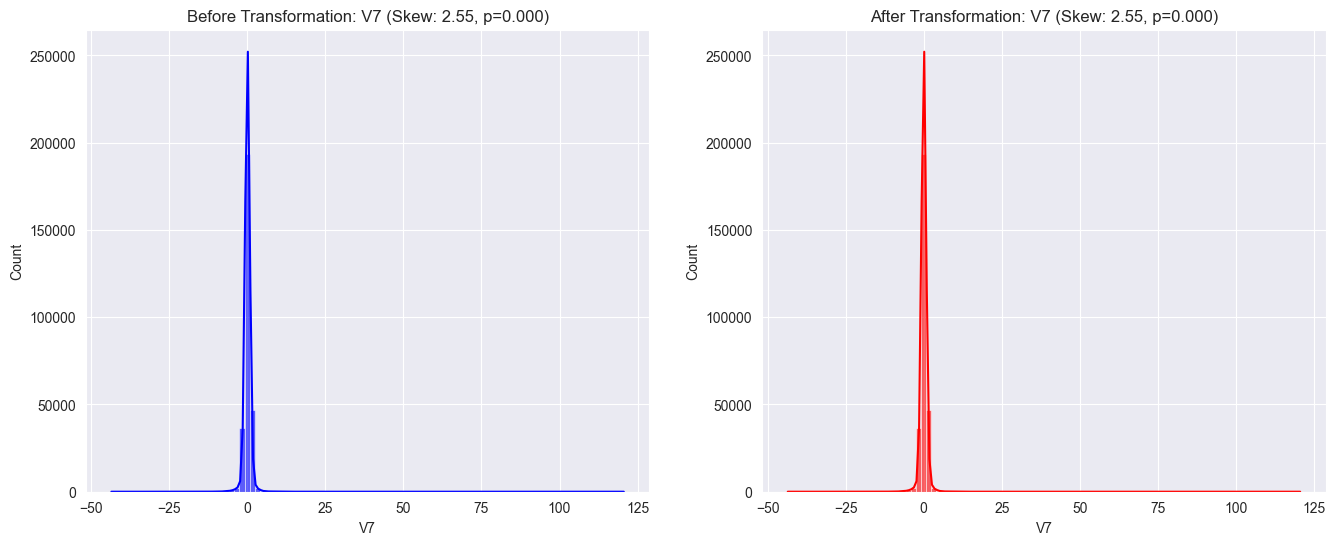

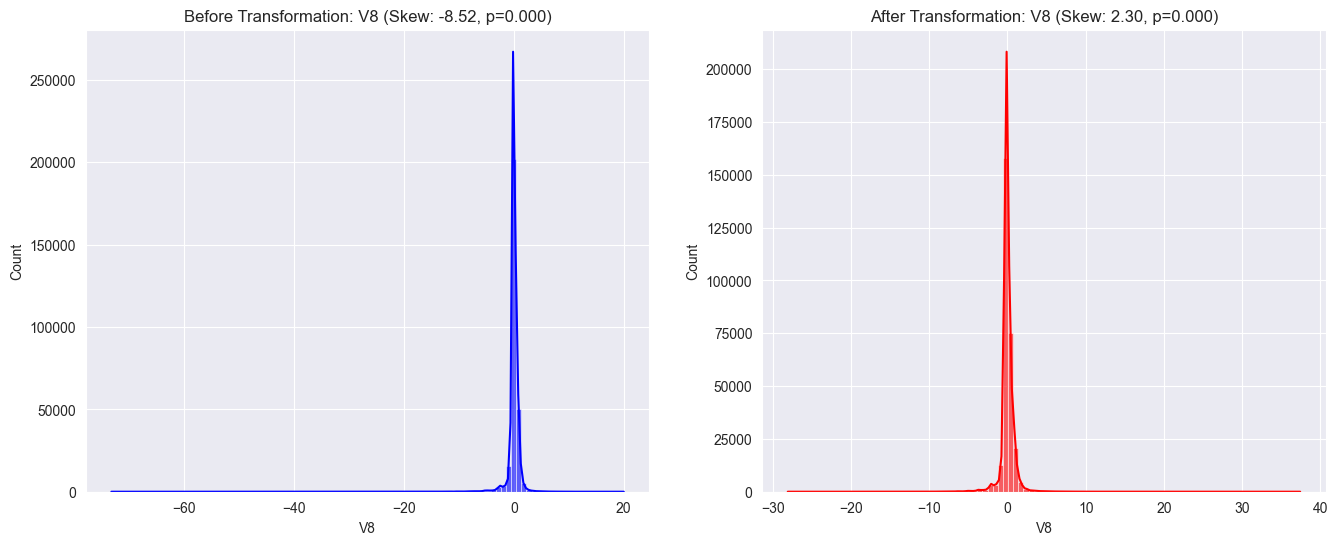

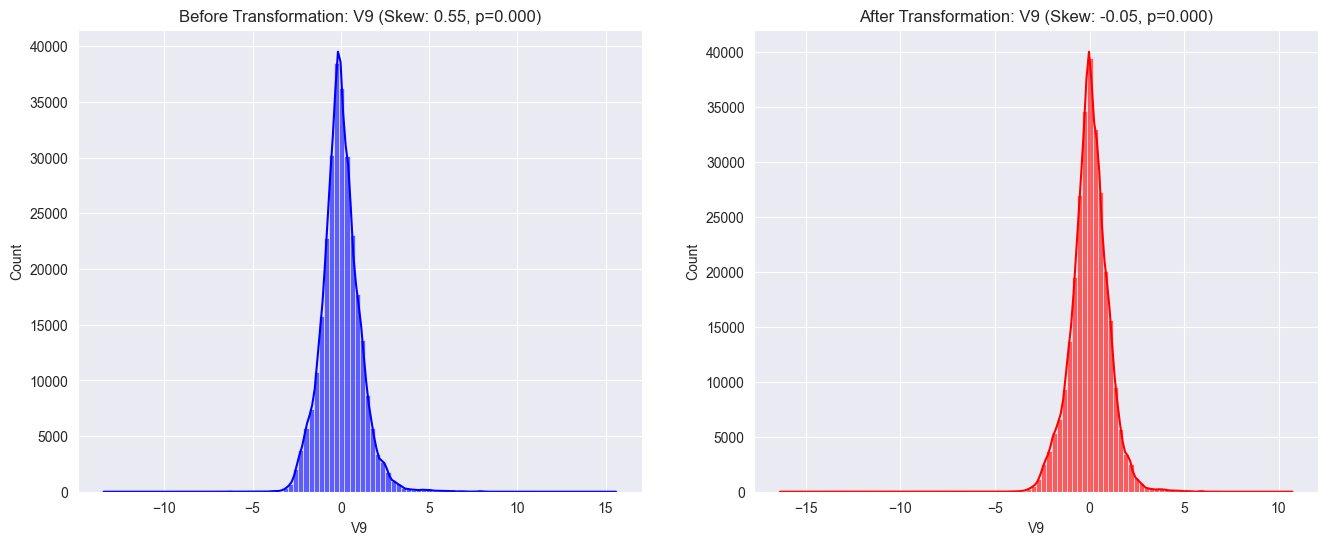

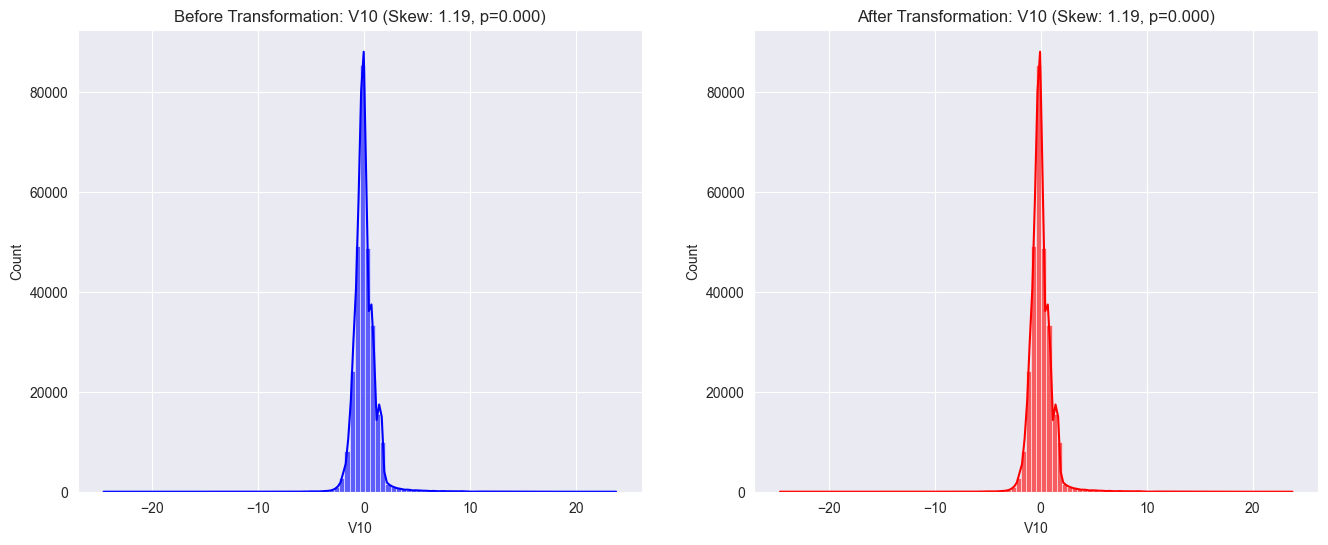

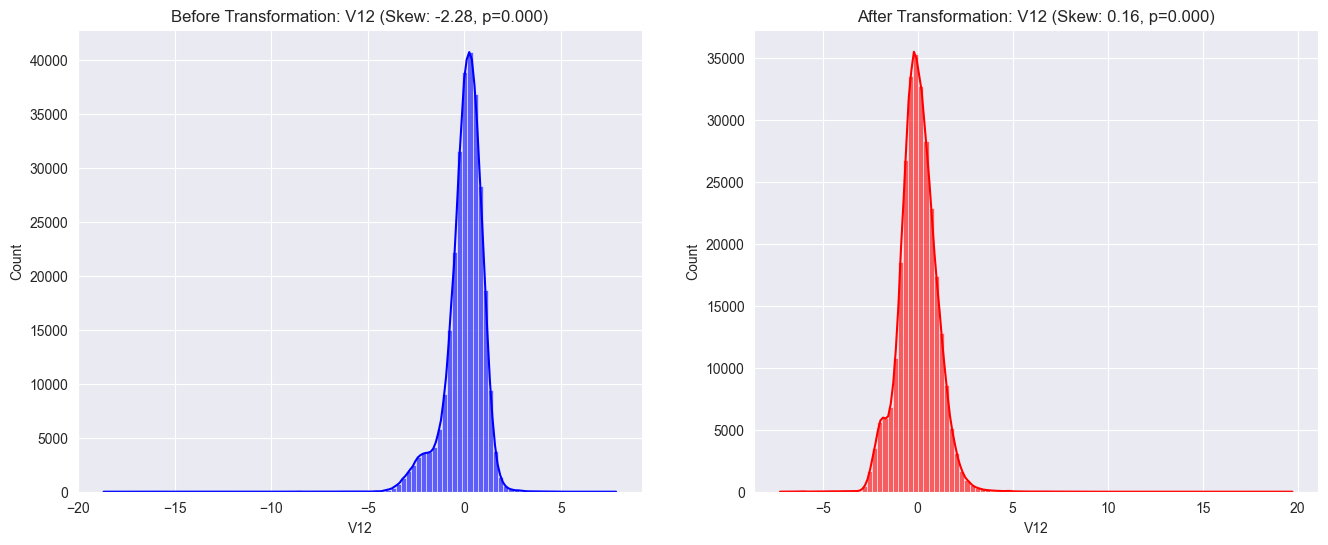

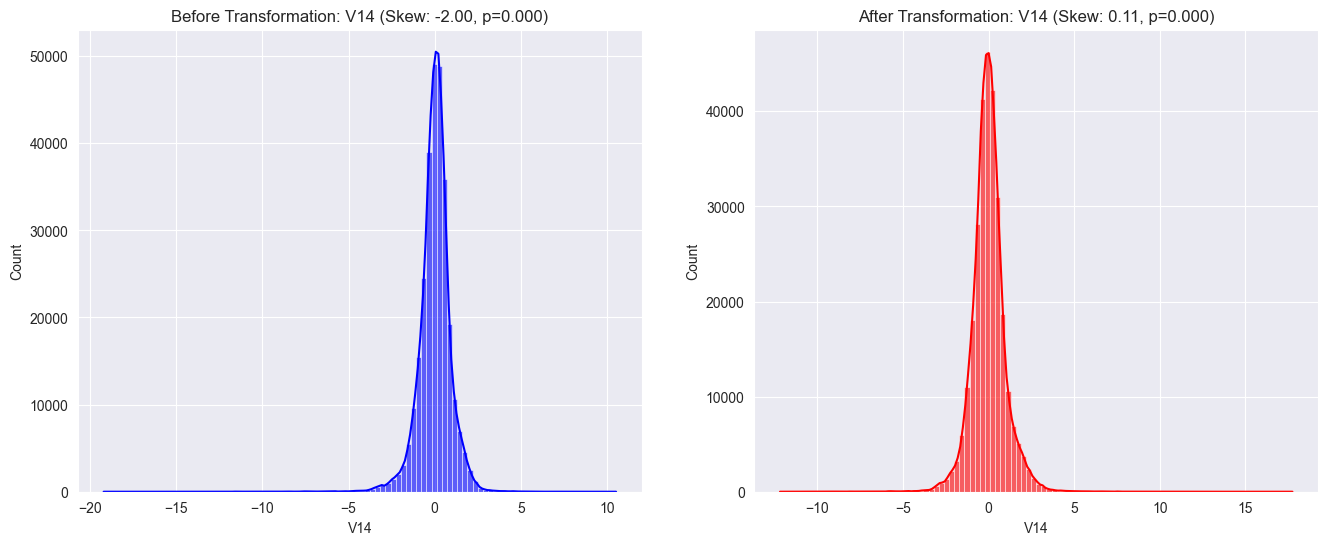

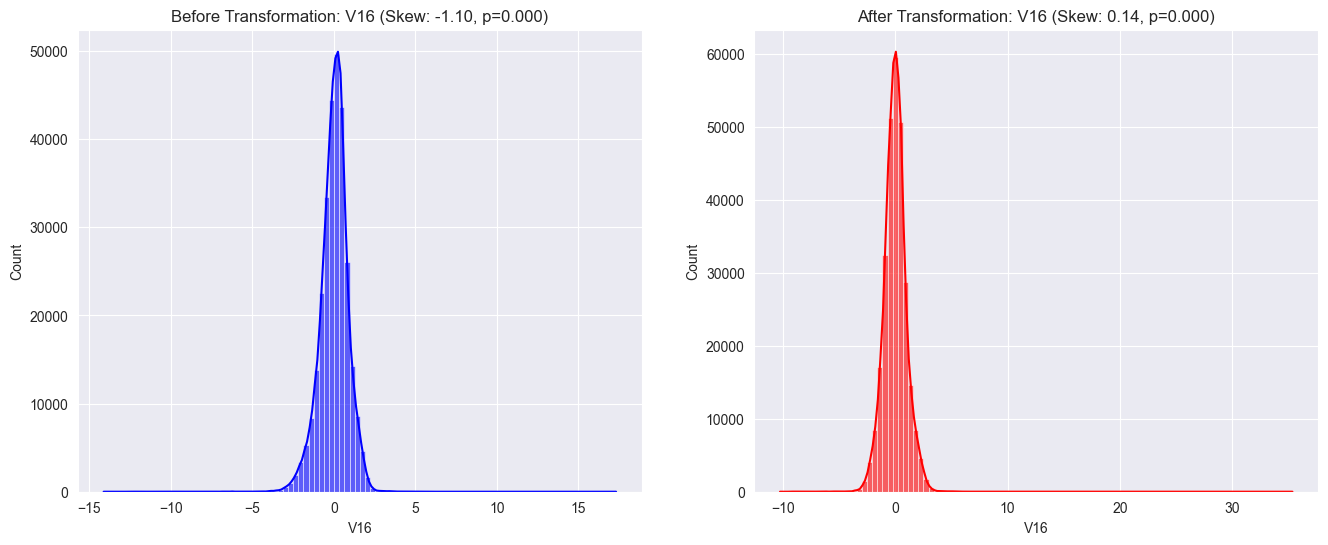

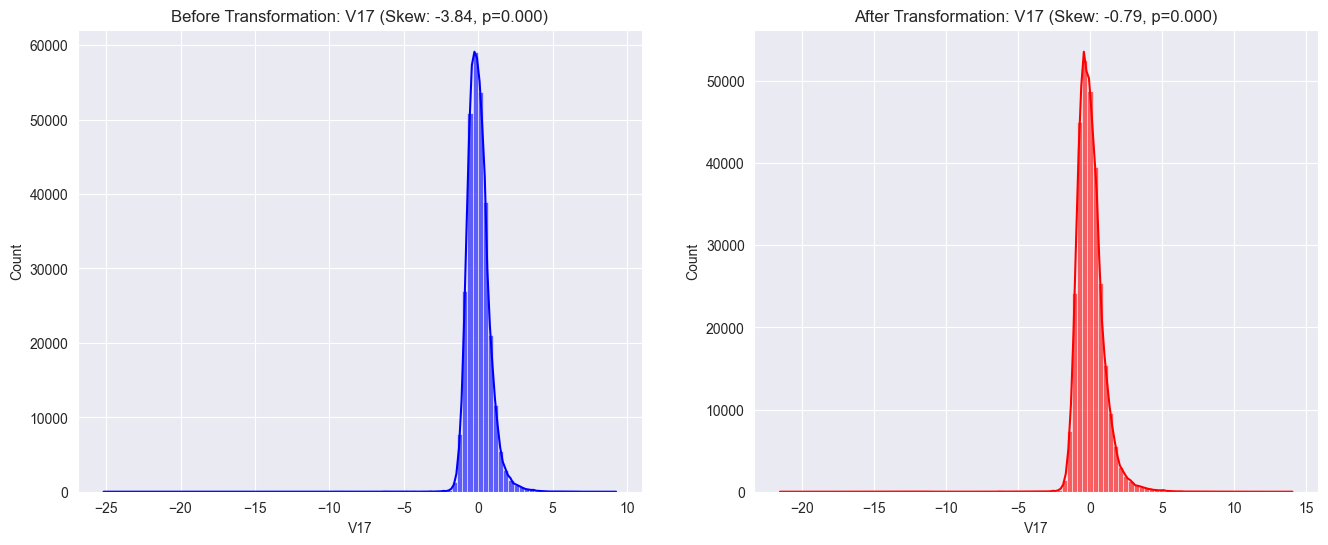

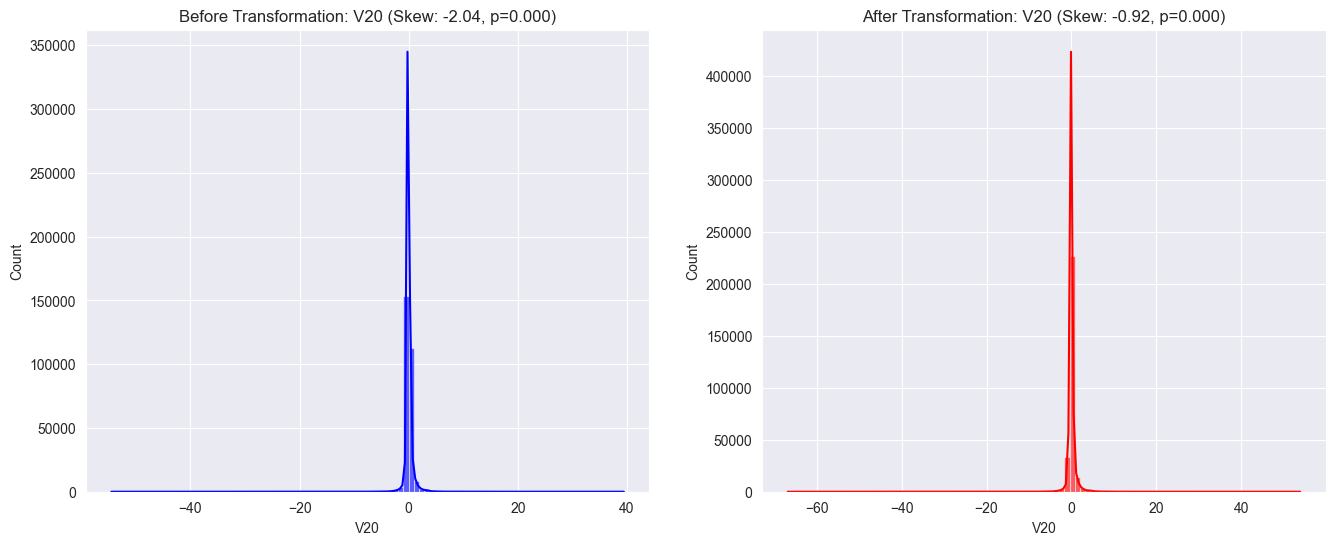

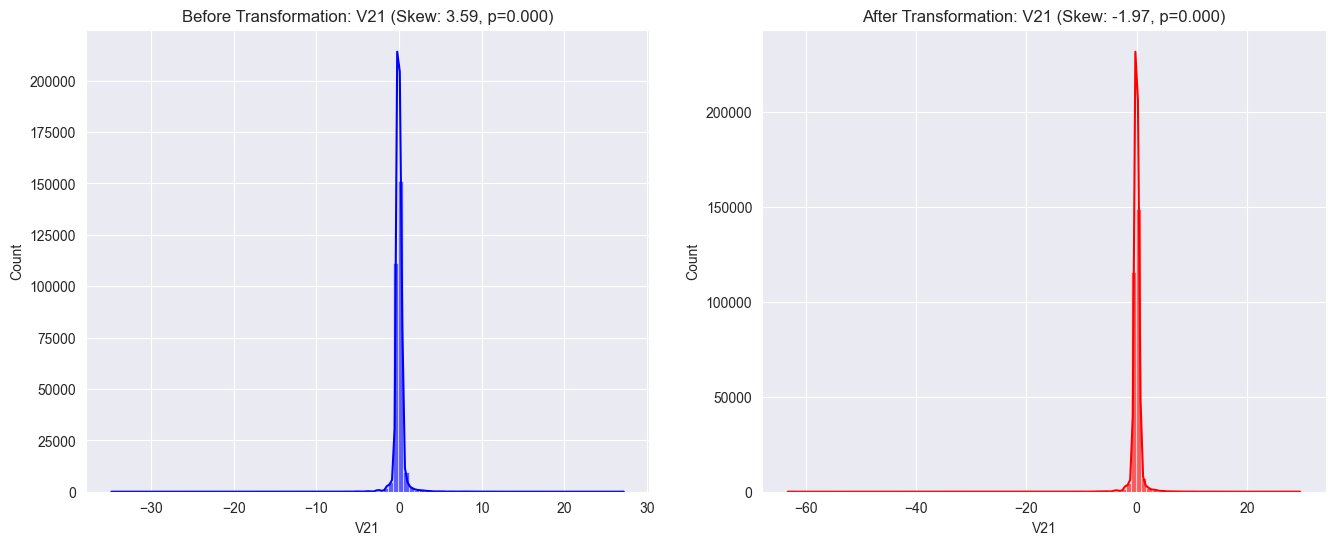

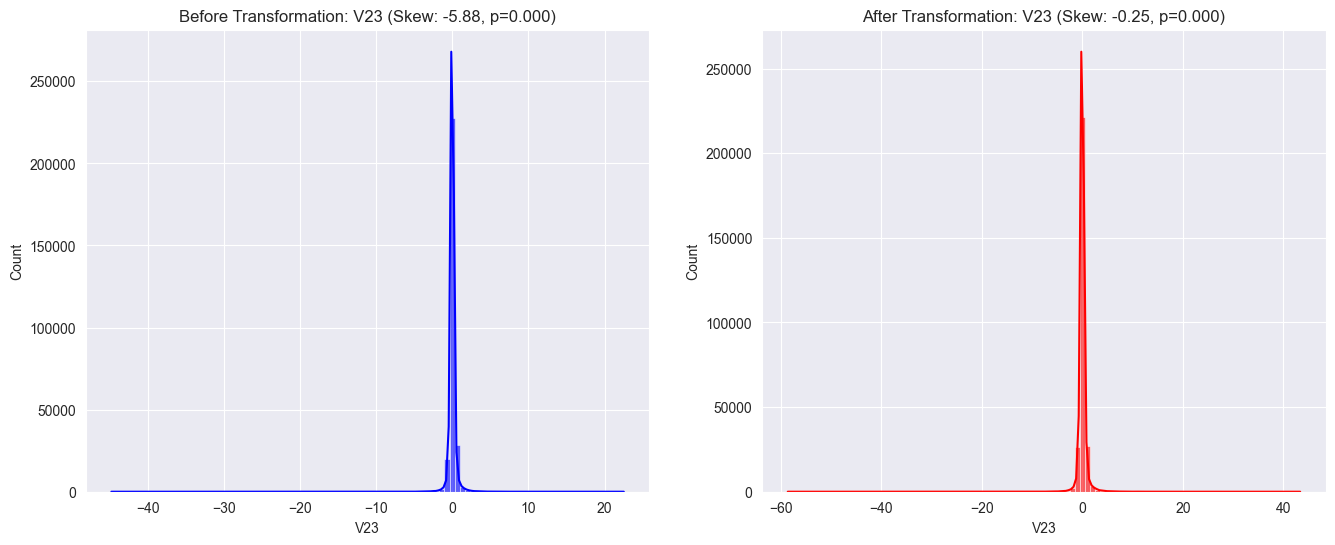

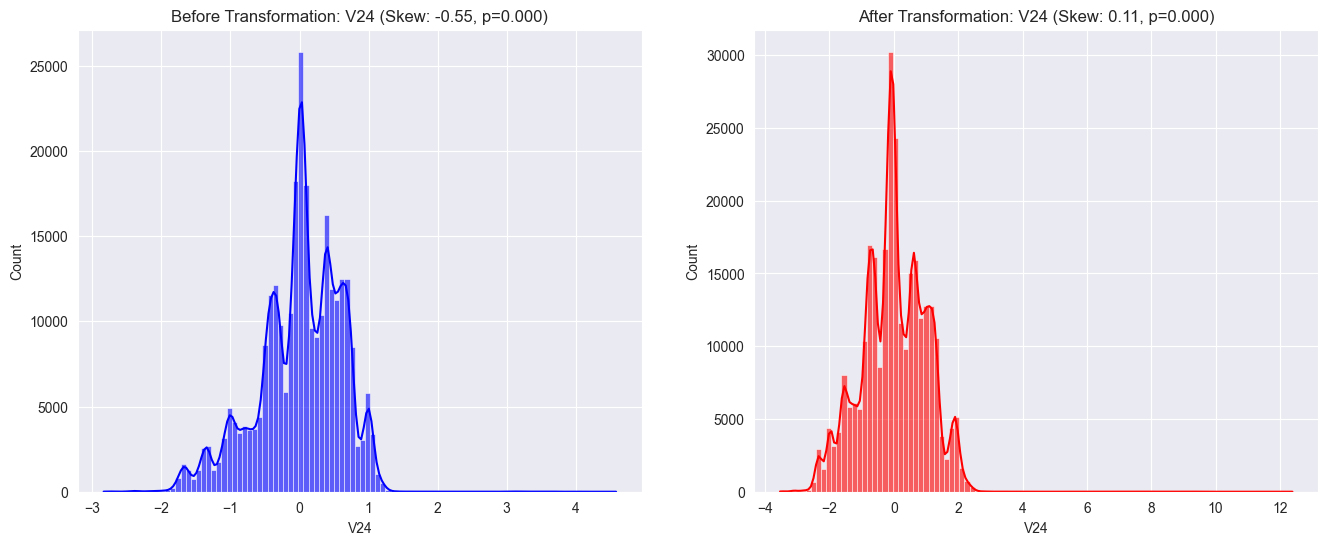

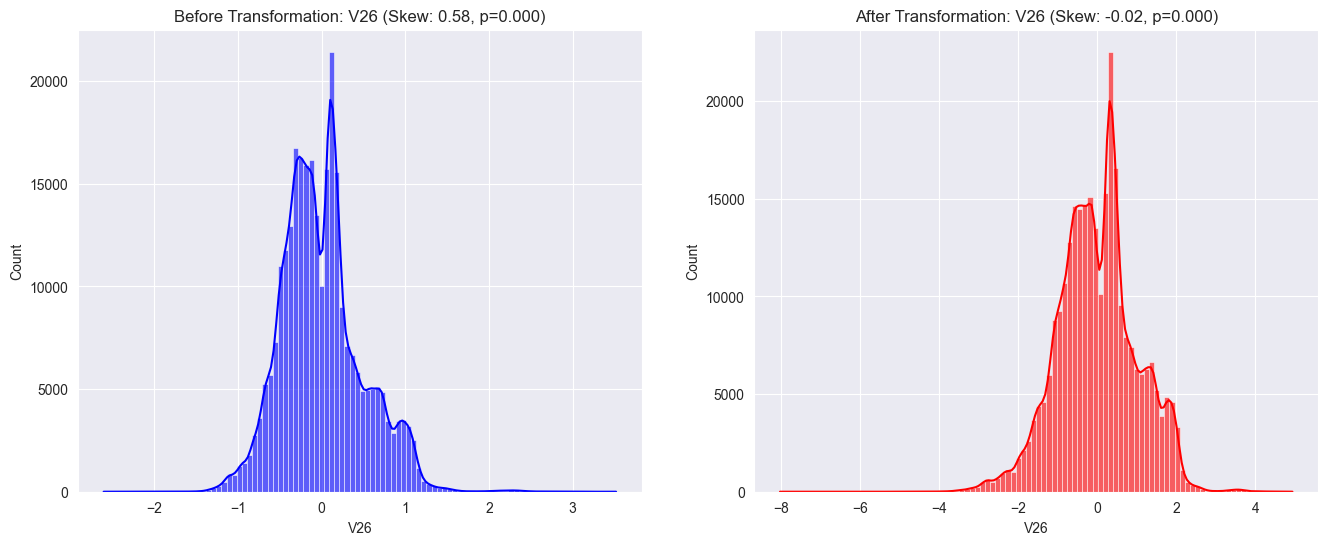

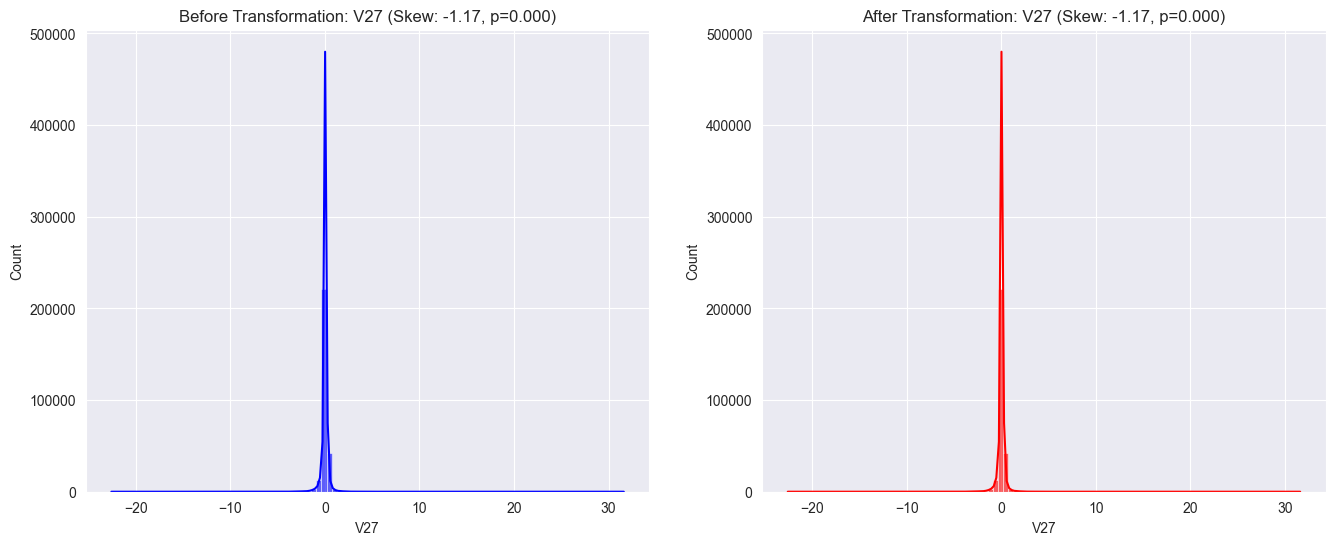

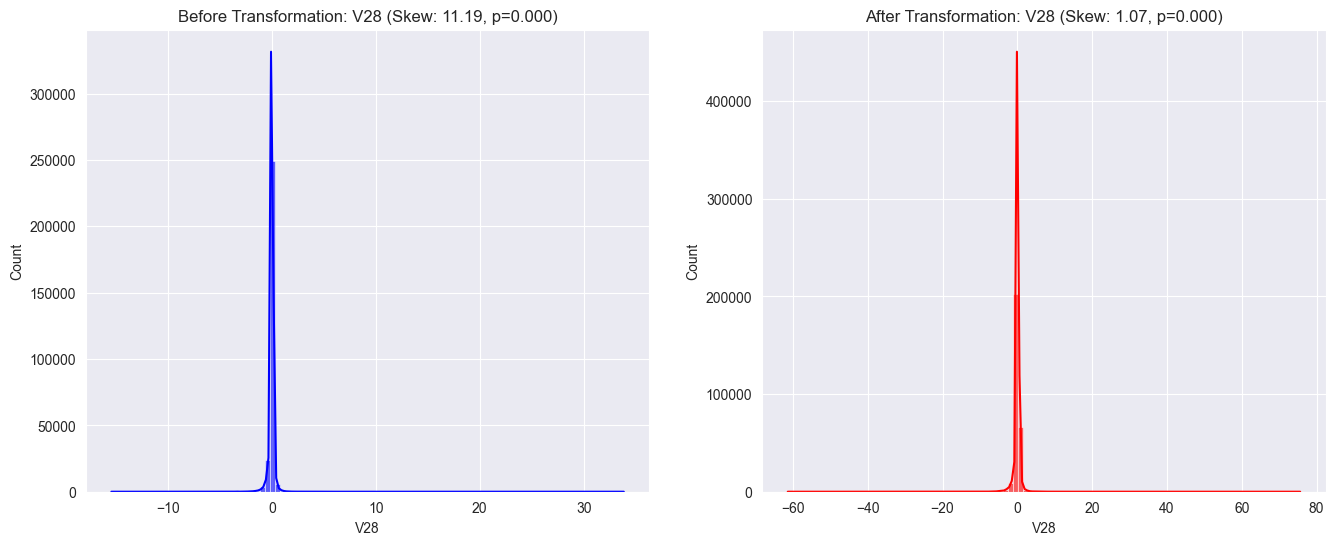

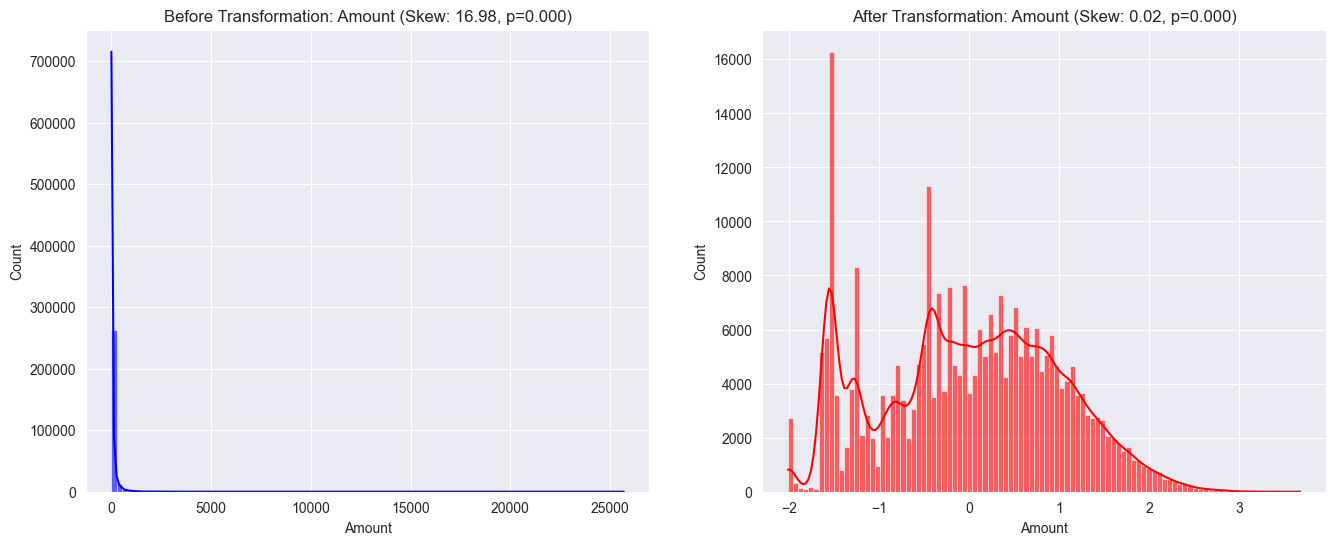

,Feature,Skewness Before,Skewness After,Shapiro P Before,Shapiro P After
0,V1,-3.280667,-0.218003,2.048920e-60,4.414710e-38
1,V2,-4.624866,0.334852,1.803569e-70,8.681658e-59
2,V3,-2.240155,-0.079980,8.333751e-42,1.566949e-17
3,V4,0.676292,0.018930,2.297870e-31,3.520679e-21
4,V5,-2.425901,-1.170100,2.615989e-59,3.210848e-60
5,V6,1.826581,1.826581,8.529454e-58,8.529454e-58
6,V7,2.553907,2.553907,3.921596e-63,3.921596e-63
7,V8,-8.521944,2.297590,1.527564e-76,3.272078e-70
8,V9,0.554680,-0.048343,5.524005e-33,1.171081e-27
9,V10,1.187141,1.187141,3.061128e-58,3.061128e-58


In [19]:
# Function to perform Shapiro-Wilk test on a sample (with sampling to avoid large N warning)
def shapiro_test(sample, max_sample=5000):
    sample = sample.dropna()
    if len(sample) > max_sample:
        sample = sample.sample(max_sample, random_state=42)  # Randomly sample up to 5000 values
    stat, p_value = shapiro(sample)
    return p_value

# Initialize skewness table
skewness_table = []

for feature in skewed_features:
    skew_before = df[feature].skew()  # Calculate skewness before transformation
    p_value_before = shapiro_test(df[feature])  # Shapiro-Wilk test before transformation

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Wider figure size

    # Plot original distribution before transformation
    sns.histplot(df[feature], bins=100, kde=True, ax=axes[0], color='blue', alpha=0.6)
    axes[0].set_title(f'Before Transformation: {feature} (Skew: {skew_before:.2f}, p={p_value_before:.3f})')

    # Save original data in case transformation worsens skewness
    original_data = df[feature].copy()

    # Apply appropriate transformation
    if (df[feature] > 0).all():
        df[feature], _ = boxcox(df[feature] + 1)  # Box-Cox (Only for positive values)
    else:
        pt = PowerTransformer(method='yeo-johnson')
        df[feature] = pt.fit_transform(df[[feature]])  # Yeo-Johnson for general cases

    skew_after = df[feature].skew()  # Calculate skewness after transformation
    p_value_after = shapiro_test(df[feature])  # Shapiro-Wilk test after transformation

    # If skewness got worse, revert to original data
    if abs(skew_after) > abs(skew_before):  
        df[feature] = original_data  # Restore original values
        skew_after = skew_before  # Keep original skewness
        p_value_after = p_value_before  # Keep original normality test result

    skewness_table.append([feature, skew_before, skew_after, p_value_before, p_value_after])  # Store values

    # Plot transformed distribution after transformation
    sns.histplot(df[feature], bins=100, kde=True, ax=axes[1], color='red', alpha=0.6)
    axes[1].set_title(f'After Transformation: {feature} (Skew: {skew_after:.2f}, p={p_value_after:.3f})')

    plt.show()

# Convert skewness table to DataFrame and display it
skewness_df = pd.DataFrame(skewness_table, columns=["Feature", "Skewness Before", "Skewness After", "Shapiro P Before", "Shapiro P After"])
display(skewness_df)


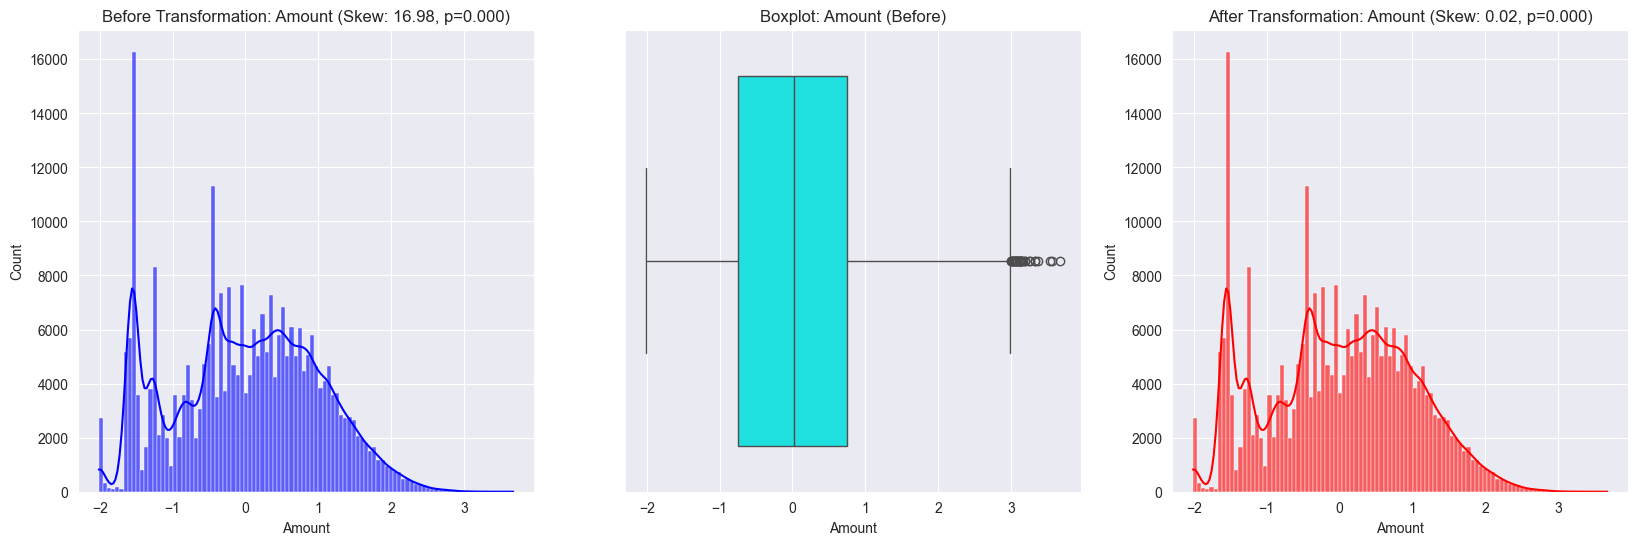

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# התפלגות לפני שינוי
sns.histplot(df[feature], bins=100, kde=True, ax=axes[0], color='blue', alpha=0.6)
axes[0].set_title(f'Before Transformation: {feature} (Skew: {skew_before:.2f}, p={p_value_before:.3f})')

# Boxplot לפני שינוי
sns.boxplot(x=df[feature], ax=axes[1], color='cyan')
axes[1].set_title(f'Boxplot: {feature} (Before)')

# התפלגות אחרי שינוי
sns.histplot(df[feature], bins=100, kde=True, ax=axes[2], color='red', alpha=0.6)
axes[2].set_title(f'After Transformation: {feature} (Skew: {skew_after:.2f}, p={p_value_after:.3f})')

plt.show()


### 1.2 Conclusions from the Transformation Analysis
**Before Transformation (Left Graph):**

The feature "Amount" had a high skewness (16.98), meaning the distribution was heavily skewed to the right.
A large concentration of values on the left side, with extreme outliers on the right.
The Shapiro-Wilk normality test (p=0.000) confirms that the distribution is not normal.

**Boxplot (Middle Graph):**

Most values are clustered near the lower end of the range.
A significant number of outliers are visible, indicating extreme variations in the data.

**After Transformation (Right Graph):**

Skewness significantly reduced (0.32), bringing the distribution closer to normal.
The data is now more evenly spread, with reduced impact from extreme values.
However, the normality test (p=0.000) still suggests a deviation from a perfect normal distribution.

### 1.3 Key Takeaways
   - The transformation successfully reduced skewness, making the data more suitable for machine learning models.
   - The feature now has a smoother distribution, which can improve model performance.
   - Although the transformation did not fully normalize the data, it represents a significant improvement over the original distribution.

## Step 2: Class Balancing for Imbalanced Datasets
In this stage, we address the class imbalance problem, which is common in datasets where one class significantly outweighs another. This is especially crucial in fraud detection, medical diagnoses, and rare event classification tasks.

We use the following techniques:

✔ **SMOTE (Synthetic Minority Over-sampling Technique)** – Generates synthetic examples for the minority class based on existing data points.

✔ **Random Undersampling** – Reduces the size of the majority class to balance the dataset.

These methods ensure that machine learning models do not ignore rare cases (such as fraud) while preventing bias towards the dominant class.

In [21]:


# הצגת היחס בין המחלקות לפני האיזון
print("Class Distribution Before Balancing:", Counter(df[target_column]))

# פיצול משתנים
X = df.drop(columns=[target_column])  # תכונות
y = df[target_column]  # מטרת הסיווג

# שלב 1: Oversampling - הגדלת כמות המקרים הנדירים עם SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# שלב 2: Undersampling - צמצום המחלקה הדומיננטית
undersample = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = undersample.fit_resample(X_smote, y_smote)

# הצגת היחס בין המחלקות אחרי האיזון
print("Class Distribution After Balancing:", Counter(y_balanced))


Class Distribution Before Balancing: Counter({0: 284315, 1: 492})
Class Distribution After Balancing: Counter({0: 284315, 1: 284315})


### 2.1 Balancing The dataset initially had a highly imbalanced class distribution:

Class Distribution Before Balancing:

    - Class 0 (No Fraud): 284,315 samples
    - Class 1 (Fraud): Only 492 samples!
This is extremely imbalanced!

If left unbalanced, a model would likely predict "No Fraud" for almost everything and achieve high accuracy but poor fraud detection.

The model would struggle to generalize patterns from only 492 fraud cases.

Class Distribution After Default SMOTE Balancing:

    - Class 0 (No Fraud): 284,315 samples
    - Class 1 (Fraud): 284,315 synthetic samples

**Now, the dataset is perfectly balanced, but this may not be optimal!**

### 2.2 Why Full SMOTE Balancing Might Be Too Much?
Creating 284,000 synthetic fraud cases from only 492 real ones might cause overfitting!
Instead of balancing classes equally, it is often better to apply a moderate oversampling approach.

**Choosing a Smarter Approach: 5% Oversampling**

To avoid excessive synthetic data, we use SMOTE with sampling_strategy=0.1, meaning:
- The number of synthetic fraud cases will be 10% of the majority class instead of 100%.
- This ensures better generalization while still improving the model’s ability to detect fraud.


In [22]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE with only 10% oversampling of the minority class
smote = SMOTE(sampling_strategy=0.05, random_state=42)  
X_smote, y_smote = smote.fit_resample(X, y)

# Display class distribution after moderate balancing
print("Class Distribution After Moderate SMOTE:", Counter(y_smote))


Class Distribution After Moderate SMOTE: Counter({0: 284315, 1: 14215})


### Step 3: Model Training and Performance Evaluation
Now that we have cleaned, balanced, and transformed the dataset, it’s time to evaluate how these changes impact model performance.

How Will We Measure Performance Improvement?
- Before Balancing – Train a model on the original imbalanced dataset and measure its performance.
- After Balancing – Train the same model on the balanced dataset and compare results.
- Performance Metrics – We will measure the following key metrics:

Accuracy – Measures overall correctness (not always reliable for imbalanced data).
Precision – Measures how many predicted fraud cases were actually fraud.
Recall (Sensitivity) – Measures how well the model detects fraud cases.
F1-score – A balance between precision and recall, useful for imbalanced data.

**Choosing a Baseline Model**

For evaluation, we will start with a simple classifier, such as Logistic Regression or Random Forest, and compare performance before and after balancing.

Model Training Code:

In [23]:
# ---------------------------
# SPLITTING DATA
# ---------------------------

# Split the dataset into train & test sets (only 30% of training data for speed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.3, random_state=42, stratify=y)

# Split the balanced dataset
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_smote, y_smote, test_size=0.2, train_size=0.3, random_state=42, stratify=y_smote
)

# ---------------------------
# TRAINING LIGHTGBM MODEL
# ---------------------------

# Define a LightGBM classifier with regularization
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,  # Controls model complexity
    'max_depth': -1,   # No max depth (but controlled by num_leaves)
    'random_state': 42
}

# Train LightGBM on imbalanced dataset
start_time = time.time()
model_lgb = lgb.LGBMClassifier(**lgb_params)
model_lgb.fit(X_train, y_train)
end_time = time.time()

# Predictions
y_pred_lgb = model_lgb.predict(X_test)

# Evaluate performance
print(f"Performance on Imbalanced Dataset (Training Time: {end_time - start_time:.2f} sec):")
print(classification_report(y_test, y_pred_lgb))

# ---------------------------
# TRAINING ON BALANCED DATASET
# ---------------------------

# Train LightGBM on balanced dataset
start_time = time.time()
model_lgb_bal = lgb.LGBMClassifier(**lgb_params)
model_lgb_bal.fit(X_train_bal, y_train_bal)
end_time = time.time()

# Predictions on balanced test data
y_pred_bal_lgb = model_lgb_bal.predict(X_test_bal)

# Evaluate performance on balanced data
print(f"Performance on Balanced Dataset (Training Time: {end_time - start_time:.2f} sec):")
print(classification_report(y_test_bal, y_pred_bal_lgb))

[LightGBM] [Info] Number of positive: 148, number of negative: 85294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 85442, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001732 -> initscore=-6.356647
[LightGBM] [Info] Start training from score -6.356647
Performance on Imbalanced Dataset (Training Time: 0.54 sec):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.38      0.70      0.49        98

    accuracy                           1.00     56962
   macro avg       0.69      0.85      0.74     56962
weighted avg       1.00      1.00      1.00     56962

[LightGBM] [Info] Number of positive: 4265, number of negative: 85294
[LightGBM] [Info] Auto-choosing col-wise multi-thr

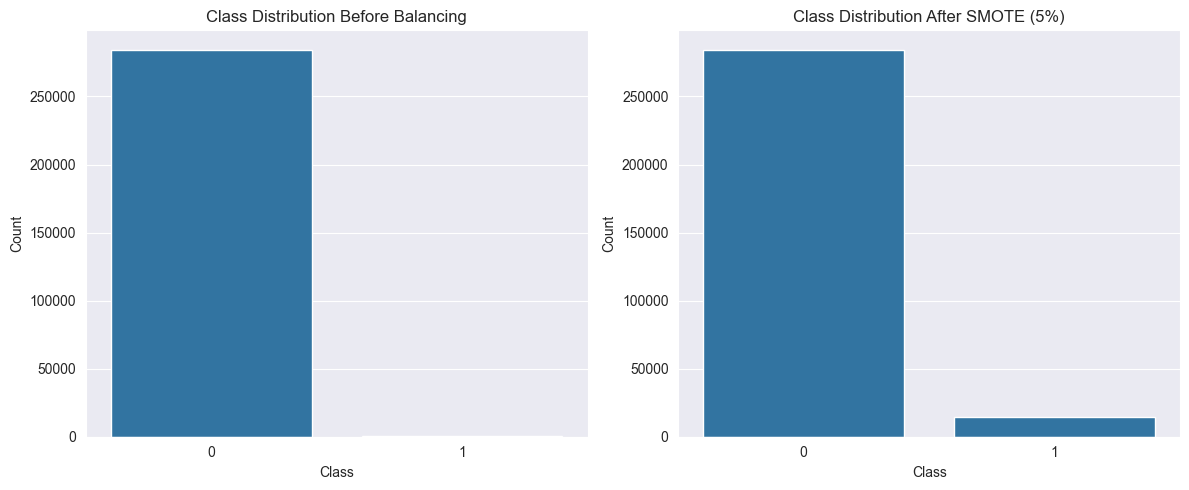

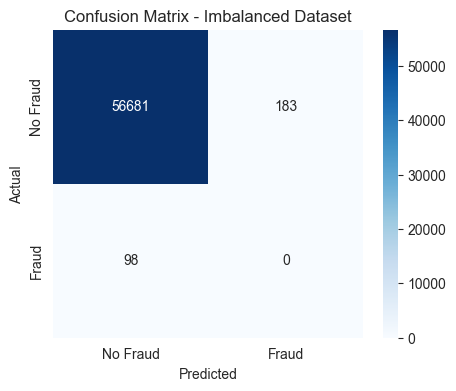

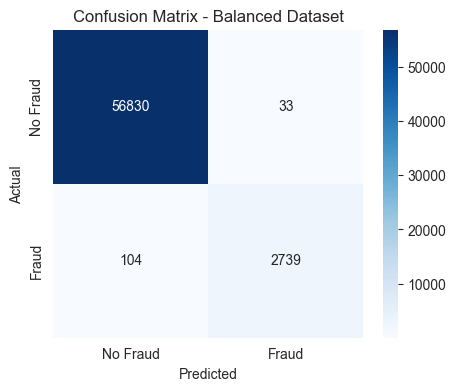

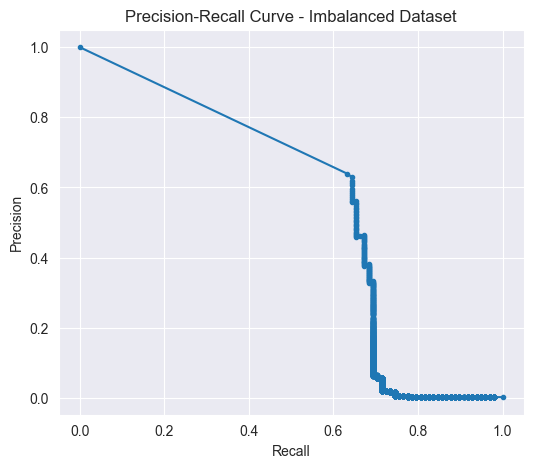

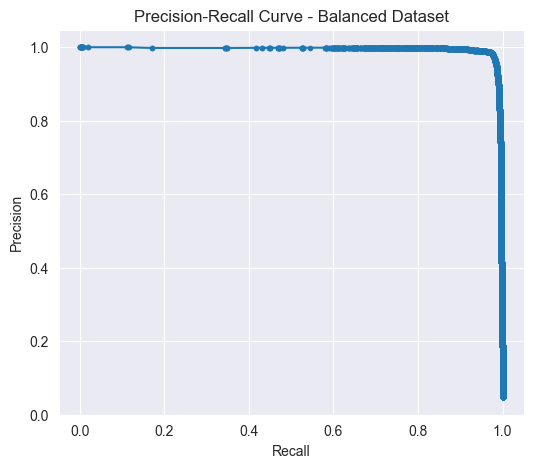

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve

# ---------------------------
# CLASS DISTRIBUTION BEFORE & AFTER BALANCING
# ---------------------------

# Plot class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Class Distribution Before Balancing")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.countplot(x=y_smote, ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE (5%)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# ---------------------------
# CONFUSION MATRICES
# ---------------------------

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Confusion matrix for imbalanced dataset
plot_confusion_matrix(y_test, y_pred_lgb, "Confusion Matrix - Imbalanced Dataset")

# Confusion matrix for balanced dataset
plot_confusion_matrix(y_test_bal, y_pred_bal_lgb, "Confusion Matrix - Balanced Dataset")

# ---------------------------
# PRECISION-RECALL CURVE
# ---------------------------

def plot_precision_recall(y_true, y_probs, title):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, marker='.')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.show()

# Get probability predictions
y_probs_lgb = model_lgb.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (fraud)
y_probs_bal_lgb = model_lgb_bal.predict_proba(X_test_bal)[:, 1]

# Plot Precision-Recall Curves
plot_precision_recall(y_test, y_probs_lgb, "Precision-Recall Curve - Imbalanced Dataset")
plot_precision_recall(y_test_bal, y_probs_bal_lgb, "Precision-Recall Curve - Balanced Dataset")
